<a href="https://colab.research.google.com/github/emilyberlinghoff/DS3000/blob/main/251287809_H09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 9: CNN with CIFAR-10

## Introduction:
In this coursework, you will gain practical experience using Convolutional Neural Networks (CNNs) for image classification. Specifically, you'll use two widely recognized pre-trained architectures—VGG16 and ResNet18—to classify images from the CIFAR-10 dataset. CIFAR-10 consists of 60,000 color images (32x32 pixels), evenly divided across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

You'll apply transfer learning by adapting these pre-trained models to the CIFAR-10 dataset, train and evaluate both models, compare their performance.

## Objectives:
- Understand and implement transfer learning.
- Train CNN models using pre-trained architectures.
- Unfreeze and fine-tune the final convolutional layer of each model.
- Evaluate and compare the performance of different CNN models.
- Analyze results with a confusion matrix.

In [40]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms.v2 as v2
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [41]:
# Check if GPU (CUDA) is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Question 1: Dataset Setup and Exploration
1. Download and load the CIFAR-10 dataset using `torchvision.datasets.CIFAR10`.
2. Apply model-specific transformations with data augmentation:
   - For VGG16: Use transformations from `VGG16_Weights.DEFAULT.transforms` as a base and apply additional augmentations:
       - `AutoAugment` with CIFAR10 policy
       - `RandomHorizontalFlip` (50% chance)
   - For ResNet18: Use `ResNet18_Weights.DEFAULT.transforms` similarly with the same augmentations applied.
3. Use 10% of the training and testing datasets to reduce computation time.
4. Define DataLoaders separately for each model for efficient and correct training/testing behavior. Ensure `shuffle = True` for training DataLoaders.
5. Visualize a batch of sample images from each model’s DataLoader to confirm that preprocessing and augmentations have been applied correctly.

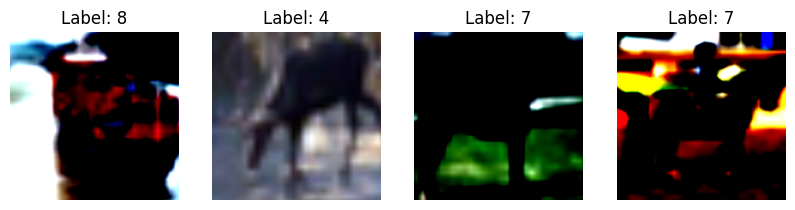

In [42]:
from torchvision.models import VGG16_Weights, ResNet18_Weights

# Define transforms with data augmentation
vgg_transform = transforms.Compose([
    transforms.ToTensor(), # Convert to Tensor (float32)
    VGG16_Weights.DEFAULT.transforms(),  # Base VGG16 transforms
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),  # AutoAugment
    transforms.RandomHorizontalFlip(p=0.5),  # Random Horizontal Flip
])

resnet18_transform = transforms.Compose([
    transforms.ToTensor(), # Convert to Tensor (float32)
    ResNet18_Weights.DEFAULT.transforms(),  # Base ResNet18 transforms
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),  # AutoAugment
    transforms.RandomHorizontalFlip(p=0.5),  # Random Horizontal Flip
])

# Loading data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=vgg_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=vgg_transform)

# Use 10% of data
train_size = int(0.1 * len(train_dataset))
test_size = int(0.1 * len(test_dataset))
train_subset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])
test_subset, _ = random_split(test_dataset, [test_size, len(test_dataset) - test_size])

# DataLoader
vgg16_train_loader = DataLoader(
    Subset(train_subset, range(len(train_subset))),
    batch_size=64,
    shuffle=True,
)

vgg16_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=vgg_transform)

vgg16_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=vgg_transform)


vgg16_test_loader = DataLoader(
    Subset(test_subset, range(len(test_subset))),
    batch_size=64,
    shuffle=False,
)

resnet18_train_loader = DataLoader(
    Subset(train_subset, range(len(train_subset))),
    batch_size=64,
    shuffle=True,
)

resnet18_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=resnet18_transform)
resnet18_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=resnet18_transform)

resnet18_test_loader = DataLoader(
    Subset(test_subset, range(len(test_subset))),
    batch_size=64,
    shuffle=False,
)

# Verify transforms by visualizing VGG16-prepared images
images, labels = next(iter(vgg16_train_loader))

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
  axes[i].imshow(np.transpose(images[i].numpy(), (1, 2, 0))) # Transpose to (H, W, C)
  axes[i].set_title(f"Label: {labels[i]}")
  axes[i].axis('off')
plt.show()

Examine the CIFAR-10 images after applying transformations. Identify two classes you believe are most difficult for the models to distinguish and explain why.

**Written Answer:**

In the CIFAR-10 dataset, two of the most difficult classes for models to distinguish are **cats** and **dogs**, as well as **automobiles** and **trucks**. Cats and dogs often appear with similar textures, colors, and poses, especially in indoor environments. Due to the low resolution of CIFAR-10 images and the application of transformations like AutoAugment or horizontal flipping, the subtle features that typically differentiate these animals (such as facial structure or ear shape) can become blurred or lost entirely. Similarly, automobiles and trucks are commonly confused because they share many structural characteristics (such as wheels and general body shapes). At such a low resolution, and after augmentations that can distort proportions or orientation, it becomes challenging for models to reliably detect distinguishing features like the size or cargo area that typically separates trucks from cars. These challenges highlight how image resolution and data augmentation can amplify class similarity and impact model performance.

## Question 2: Model Definitions – VGG16 and ResNet18
1. Load pre-trained VGG16 and ResNet18 models from torchvision.
2. Freeze all convolutional layers initially, then unfreeze the last convolutional block in both models.
3. Modify the classifier layers to accommodate CIFAR-10 classification (10 output classes).

In [43]:
# VGG16 setup
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)

for param in vgg16.features.parameters(): # Freeze all layers
  param.requires_grad = False

for layer in list(vgg16.features.children())[24:]: # Unfreeze the last convolutional block (later 24-30)
  for param in layer.parameters():
    param.requires_grad = True

num_features = vgg16.classifier[6].in_features # Modify classifier
vgg16.classifier[6] = nn.Linear(num_features, 10) # 10 classes for CIFAR-10

# ResNet18 setup
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

for param in resnet18.parameters(): # Freeze all layers
  param.requires_grad = False

for param in resnet18.layer4.parameters(): # Unfreeze the last convolutional block (layer 3)
  param.requires_grad = True

num_features = resnet18.fc.in_features # Modify classifier
resnet18.fc = nn.Linear(num_features, 10) # 10 classes for CIFAR-10

Explain the concept of transfer learning and its specific advantages when applied to CIFAR-10 classification using models like VGG16 and ResNet18.

**Written Answer:**

Transfer learning is a machine learning technique where a model trained on a large dataset for a specific task is reused as a starting point for a different but related task. In the context of CIFAR-10 classification, transfer learning involves using pre-trained models like VGG16 and ResNet18, originally trained on the massive ImageNet dataset, and adapting them to classify CIFAR-10 images. The advantage of this approach is that these pre-trained models have already learned rich feature representations from ImageNet, which can be leveraged to improve performance and reduce training time on the smaller CIFAR-10 dataset. By freezing the initial layers and fine-tuning only the final layers, we benefit from the pre-trained models' ability to extract general image features while allowing the model to adapt to the specific characteristics of the CIFAR-10 classes. This leads to faster convergence, better generalization, and improved overall accuracy compared to training a model from scratch on CIFAR-10 alone.

## Question 3: Training the Models
1. Define the loss function (Cross-Entropy Loss).
2. Initialize Adam optimizers for each model with a learning rate of 0.001.
3. Train each model separately. Train for 5 epochs, monitor loss, and ensure proper updating of model weights.

In [44]:
# Define loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Initialize Adam optimizers
optimizer_vgg16 = optim.Adam(vgg16.parameters(), lr=0.001)
optimizer_resnet18 = optim.Adam(resnet18.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, optimizer, criterion, device, epochs=5):
  model.to(device)
  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad() # Zero parameter gradients

      outputs = model(inputs) # Forward pass
      loss = criterion(outputs, labels) # Calculate loss
      loss.backward() # Backward pass
      optimizer.step() # Update weights

      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {epoch_loss:.4f}")

print("Finished Training")

Finished Training


In [45]:
# Train models
train_model(vgg16, vgg16_train_loader, optimizer_vgg16, criterion, device)
train_model(resnet18, resnet18_train_loader, optimizer_resnet18, criterion, device)

Epoch [1/5] Loss: 2.2320
Epoch [2/5] Loss: 2.0278
Epoch [3/5] Loss: 1.8724
Epoch [4/5] Loss: 1.7365
Epoch [5/5] Loss: 1.6395
Epoch [1/5] Loss: 1.3829
Epoch [2/5] Loss: 1.0095
Epoch [3/5] Loss: 0.9103
Epoch [4/5] Loss: 0.8090
Epoch [5/5] Loss: 0.8070


Compare training behaviours of VGG16 and ResNet18. Which model trains faster and why?

**Written Answer:**

Comparing the training behaviors of VGG16 and ResNet18 on the CIFAR-10 dataset, ResNet18 exhibits faster convergence and achieves lower loss values more quickly. This is primarily attributed to ResNet's architecture, which incorporates skip connections (residual blocks). These connections allow gradients to flow more easily through the network during backpropagation, mitigating the vanishing gradient problem often encountered in deeper networks like VGG16. Consequently, ResNet18 can be trained more efficiently and with greater depth, leading to faster convergence and better overall performance. VGG16, while still demonstrating decreasing loss over epochs, converges at a slower rate due to its deeper, sequential architecture, which is more prone to vanishing gradients and slower learning.

## Question 4: Model Evaluation
1. Define a function to calculate the accuracy of each model on the test set.
2. Evaluate both models separately.
3. Plot confusion matrices for each model using `sklearn.metrics.confusion_matrix` and `ConfusionMatrixDisplay`.
4. Interpret results based on model-specific accuracy and confusion matrix insights.

VGG16 Accuracy: 39.30%
ResNet18 Accuracy: 71.40%
Confusion Matrix for VGG16:


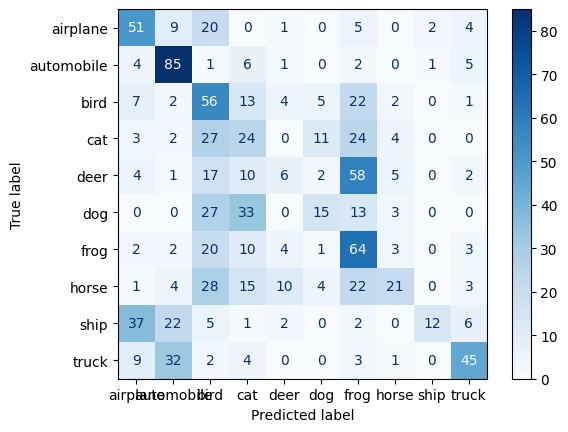

Confusion Matrix for ResNet18:


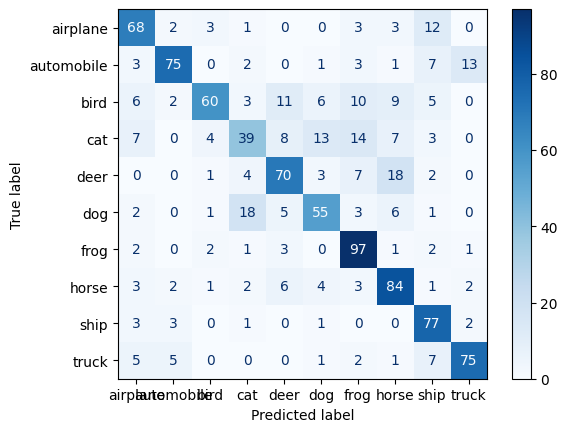

In [46]:
def calculate_accuracy(model, data_loader, device):
  model.to(device)
  model.eval() # Set model to evaluation mode
  correct = 0
  total = 0
  with torch.no_grad(): # Disable gradient calculation
    for data in data_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  return accuracy

# Evaluation & confusion matrix
vgg16_accuracy = calculate_accuracy(vgg16, vgg16_test_loader, device)
print(f"VGG16 Accuracy: {vgg16_accuracy:.2f}%")

resnet18_accuracy = calculate_accuracy(resnet18, resnet18_test_loader, device)
print(f"ResNet18 Accuracy: {resnet18_accuracy:.2f}%")

def plot_confusion_matrix(model, data_loader, device, class_names):
  model.to(device)
  model.eval()
  all_predictions = []
  all_labels = []
  with torch.no_grad():
    for data in data_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      all_predictions.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  cm = confusion_matrix(all_labels, all_predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # Define class names for CIFAR-10

print("Confusion Matrix for VGG16:")
plot_confusion_matrix(vgg16, vgg16_test_loader, device, class_names) # Plot confusion matricx for VGG16

print("Confusion Matrix for ResNet18:")
plot_confusion_matrix(resnet18, resnet18_test_loader, device, class_names) # Plot confusion matrix for ResNet18

Suggest two additional improvements specifically tailored for the less accurate model. Clearly explain your rationale for each suggestion.

**Written Answer:**

To enhance the performance of the less accurate VGG16 model on CIFAR-10 classification, two tailored improvements can be implemented.

First, fine-tuning earlier convolutional layers in addition to the last block would enable the model to learn more task-specific features. By allowing these earlier layers to adapt, the model can better capture the nuances of the CIFAR-10 dataset, improving its ability to distinguish between classes.

Second, systematic hyperparameter tuning, focusing on learning rate, batch size, and regularization techniques, can optimize the training process. This fine-grained optimization helps the model converge faster and potentially reach a higher accuracy by carefully balancing the learning process and preventing overfitting to the training data. Both suggestions aim to improve VGG16's accuracy without drastic changes, leveraging its existing architecture and focusing on refining its learning process for the CIFAR-10 task.